<a href="https://colab.research.google.com/github/PKopel/mpr/blob/main/cuda/CUDA_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Mon May 30 22:06:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%writefile gputimer.h
#ifndef __GPU_TIMER_H__
#define __GPU_TIMER_H__

class GpuTimer
{
    public:
      cudaEvent_t start;
      cudaEvent_t stop;
 
      GpuTimer()
      {
            cudaEventCreate(&start);
            cudaEventCreate(&stop);
      }
 
      ~GpuTimer()
      {
            cudaEventDestroy(start);
            cudaEventDestroy(stop);
      }
 
      void Start()
      {
            cudaEventRecord(start, 0);
      }
 
      void Stop()
      {
            cudaEventRecord(stop, 0);
      }
 
      float Elapsed()
      {
            float elapsed;
            cudaEventSynchronize(stop);
            cudaEventElapsedTime(&elapsed, start, stop);
            return elapsed;
      }
};

#endif  /* __GPU_TIMER_H__ */

Overwriting gputimer.h


In [ ]:
%%writefile vector_add.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h> 
#include "gputimer.h"

extern "C" __global__ void vectorAdd(const float *A, const float *B, float *C,
                                     int numElements) {
  int start, end = 0;
  start = numElements * blockIdx.x / gridDim.x;
  end = numElements * (blockIdx.x +1) / gridDim.x;
  for(int i = threadIdx.x + start; i < end; i+=blockDim.x){
    C[i] = A[i] + B[i];
  }
}

void cpuVectorAdd(float* A, float* B, float* C, int N){
	
	for(int i=0; i < N; i++){
		C[i] = A[i] + B[i];
	}
}


int main(int argc, char *argv[]) {
    
    if (argc < 4) {
        exit(1);
    }
    int threads_per_block = atoi(argv[1]);
    int blocks_per_grid = atoi(argv[2]);
    int N = atoi(argv[3]);
    size_t size = N*sizeof(float);

    printf("%d,%d", threads_per_block, blocks_per_grid);

    float* h_a;
    float* h_b;
    float* h_c;
    cudaMallocHost(&h_a, size);
    cudaMallocHost(&h_b, size);
    cudaMallocHost(&h_c, size);
    float* h_c2 = (float*)malloc(size);
    
    for(int i = 0;i<N;i++){
        h_a[i] = 1.5;
        h_b[i] = 2.7;
    }
    
    float* d_a;
    cudaMalloc(&d_a, size);

    float* d_b;
    cudaMalloc(&d_b, size);

    float* d_c;
    cudaMalloc(&d_c, size);
    
    cudaMemcpy(d_a, h_a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_b, h_b, size, cudaMemcpyHostToDevice);
        
    GpuTimer timer;
    timer.Start();

    vectorAdd<<<blocks_per_grid, threads_per_block>>>(d_a, d_b, d_c, N);
    cudaDeviceSynchronize();
    
    timer.Stop();
    printf(",%f", timer.Elapsed());
    
    cudaMemcpy(h_c, d_c, size, cudaMemcpyDeviceToHost);

    timer.Start();

    cpuVectorAdd(h_a, h_b, h_c2, N);
    
    timer.Stop();
    printf(",%f\n", timer.Elapsed());
    
    for(int i = 0; i<N;i++){
        if(h_c[i] != h_c2[i]) {
            printf("results don't match: %d: gpu: %f cpu: %f\n", i, h_c[i], h_c2[i]);
            exit(1);
        }
    }

    cudaFree(d_a);
    cudaFree(d_b);
    cudaFree(d_c);

    cudaFreeHost(h_a);
    cudaFreeHost(h_b);
    cudaFreeHost(h_c);
    
    return 0;
}

Overwriting vector_add.cu


In [ ]:
!nvcc -o vector_add vector_add.cu

running: `./vector_add <#threads> <#blocks> <vector size>`

In [ ]:
%%writefile run.sh
#!/usr/bin/env bash

echo "threads,blocks,gpu,cpu" > results.csv

for i in 1 10 20 40 80; do
  ./vector_add $i 10 100000000 >> results.csv
done

for i in 1 10 20 40; do
  ./vector_add 100 $i 100000000 >> results.csv
done


Writing run.sh


In [ ]:
!./vector_add 100 40 100000000

100,40,18.080288,448.187134


In [ ]:
!chmod +x run.sh
!./run.sh

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
results = pd.read_csv('results.csv')
results

,threads,blocks,gpu,cpu
0,1,10,835.447266,462.882019
1,10,10,379.170105,447.296051
2,20,10,250.897629,452.262909
3,40,10,147.758469,440.720001
4,80,10,72.763519,449.013824
5,100,1,443.642578,446.573639
6,100,10,60.608032,443.461182
7,100,20,32.480896,441.134674
8,100,40,18.095680,446.583923


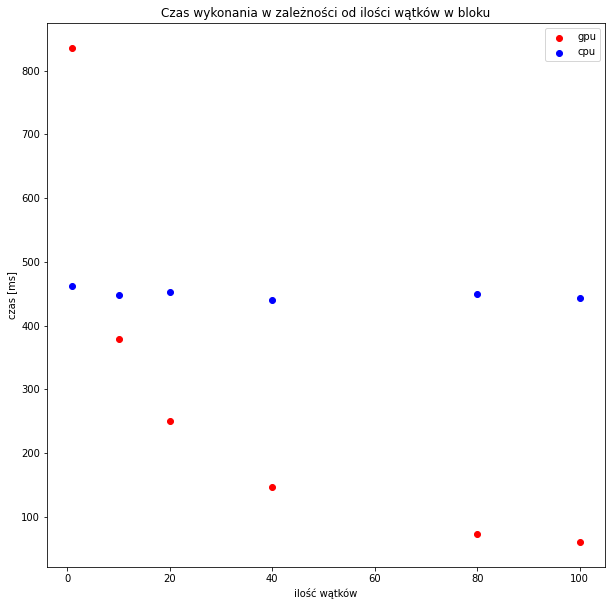

In [ ]:
plt.figure(figsize=(10,10))

by_threads = results[ results['blocks'] == 10]

plt.scatter(by_threads['threads'],by_threads['gpu'],c='r',label='gpu')
plt.scatter(by_threads['threads'],by_threads['cpu'],c='b',label='cpu')

plt.legend()
plt.title(f'Czas wykonania w zależności od ilości wątków w bloku')
plt.xlabel('ilość wątków')
plt.ylabel(f'czas [ms]')
plt.show()

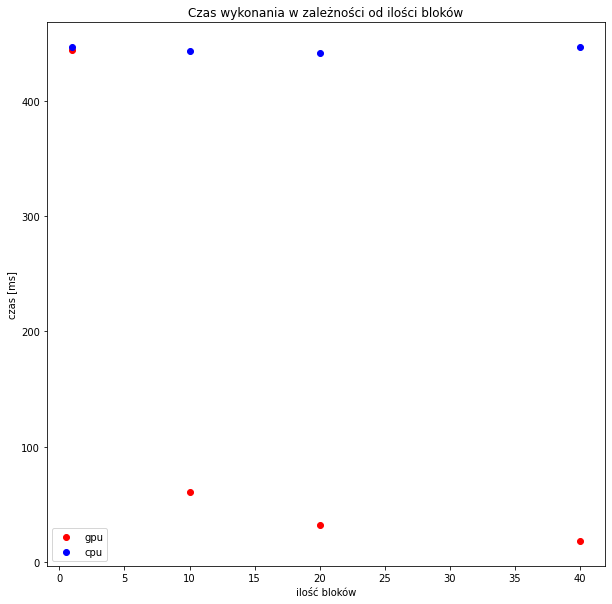

In [ ]:
plt.figure(figsize=(10,10))

by_threads = results[ results['threads'] == 100]

plt.scatter(by_threads['blocks'],by_threads['gpu'],c='r',label='gpu')
plt.scatter(by_threads['blocks'],by_threads['cpu'],c='b',label='cpu')

plt.legend()
plt.title(f'Czas wykonania w zależności od ilości bloków')
plt.xlabel('ilość bloków')
plt.ylabel(f'czas [ms]')
plt.show()